
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 4 - Function Approximators Part 2: Deep Q Network </b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Task environments </a>
* <a href='#1.2'> 1.2 Learning Objectives </a>
* <a href='#1.3'> 1.3 Code Structure & Files </a>
* <a href='#1.4'> 1.4 Execution time </a>
* <a href='#2.'> 2. A (not-so-)deep Q-network</a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>

<a href='#T1'><b>Student Task 1.</b> Implementing DQN (10 points) </a>\
<a href='#Q1'><b>Student Question 1.1</b> Considering Continuous Action Spaces (5 points) </a>\
<a href='#Q2'><b>Student Question 1.2</b> Continuous Action Spaces Part 1 (15 points) </a>\
<a href='#Q3'><b>Student Question 1.3</b> The Target Network (10 points) </a>
 

**Total Points:** 40

# 1. Introduction <a id='1.'></a>

In various real-world scenarios, dealing with high-dimensional state spaces makes it impractical to compute and store Q-values for every possible state-action pair in a Q-table. To address this challenge, we turn to function approximators. In this assignment, you will progress creating a basic Deep Q-Network (DQN) in the **Cartpole** and **LunarLander** environment.

**Please start working on this assignment early since the DQN will take some time to train.**


<div style="display:flex">
     <div style="flex:1;padding-left:100px;">
          <img src="imgs/cartpole.png" width="300"/>
         <figcaption style="flex:1;padding-left:20px;">  Figure 1: The Cartpole environment. </figcaption>
     </div>
     <div style="flex:1;padding-left:70px;">
          <img src="imgs/lunar_lander.png" width="300"/>
         <figcaption style="flex:1;padding-left:20px;">  Figure 2: The Lunarlander environment. </figcaption>
     </div>

</div>

Useful Sources:

- Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013). https://arxiv.org/pdf/1312.5602.pdf


## 1.1 Task environments: <a id='1.1'></a>
In this excercise, we will mainly use DQN for two tasks:
- Cartpole(https://gymnasium.farama.org/environments/classic_control/cart_pole/): This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

- Lunar Lander (https://gymnasium.farama.org/environments/box2d/lunar_lander/): This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

## 1.2 Learning Objectives: <a id='1.1'></a>
- Understand why and how function approximators can be used for Q-learning
- Understand the Deep Q-Network RL algorithm

## 1.3 Code Structure & Files <a id='1.2'></a>

```ex4_dqn.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex4_rbf.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───CartPole-v1
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*dqn.pt            # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*cartpole_dqn.png       # Contains training performance plot
│   └───LunarLander-v2
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*dqn.pt            # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*lunarlander_dqn.png    # Contains training performance plot
│   ex4_dqn.ipynb                   # 2nd assignment file containing tasks <---------This task
│   ex4_rbf.ipynb                   # 1st assignment file containing tasks <---------
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of these methods might take more than 40 mins depends on the server. If you have problem of experiment running takes too much time, you can download the jupyter notebook and test it locally.

# 2. A (not-so-)deep Q-network <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing DQN (10 points) </h3> 

Finish the incomplete code in DQNAgent (functions ```update``` and ```get_action```, marked with ```TODO```) to implement a DQN agent.

**See Figure 3 for an example training performance plot for cartpole. Save the training performance plots, and check if they are in the right place (the paths please refer to <a href='#3.'>Submitting<a>).**

<figure style="text-align: center">
<img src="imgs/dqn.png" width="300px">
<figcaption style="text-align: center"> Figure 3: The training performance plot for cartpole-dqn might look something like this. </figcaption>
</figure>
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from typing import List
import numpy as np
import torch, random, copy, yaml, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path

import utils as u
import train as t

from IPython.display import Video # to display videos

device = 'cpu'

In [2]:
def mlp(in_dim, mlp_dims: List[int], out_dim, act_fn=nn.ReLU, out_act=nn.Identity):
    """Returns an MLP."""
    if isinstance(mlp_dims, int): raise ValueError("mlp dimensions should be list, but got int.")

    layers = [nn.Linear(in_dim, mlp_dims[0]), act_fn()]
    for i in range(len(mlp_dims)-1):
        layers += [nn.Linear(mlp_dims[i], mlp_dims[i+1]), act_fn()]
    # the output layer
    layers += [nn.Linear(mlp_dims[-1], out_dim), out_act()]
    return nn.Sequential(*layers)

In [3]:
class DQNAgent(object):
    def __init__(self, state_shape, n_actions,
                 batch_size=32, hidden_dims=[12], gamma=0.98, lr=1e-3, grad_clip_norm=1000, tau=0.001):
        self.n_actions = n_actions
        self.state_dim = state_shape[0]
        self.policy_net = mlp(self.state_dim, hidden_dims, n_actions).to(device)
        self.target_net = copy.deepcopy(self.policy_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=float(lr))

        self.batch_size = batch_size
        self.gamma = gamma
        self.grad_clip_norm = grad_clip_norm
        self.tau = tau
        
        self.counter = 0

    def update(self, buffer):
        """ One gradient step, update the policy net."""
        start = time.perf_counter()
        self.counter += 1
        # Do one step gradient update
        batch = buffer.sample(self.batch_size, device=device)
        # Hint:
        #    state = batch.state
        #    action = batch.action 
        #    next_state = batch.next_state
        #    reward = batch.reward 
        #    not_done = batch.not_done 
        
        # TODO: Task 3: Finish the DQN implementation.
        # Hints: 1. You can use torch.gather() to gather values along an axis specified by dim. 
        #        2. torch.max returns a namedtuple (values, indices) where values is the maximum 
        #           value of each row of the input tensor in the given dimension dim.
        #           And indices is the index location of each maximum value found (argmax).
        #        3.  batch is a namedtuple, which has state, action, next_state, not_done, reward
        #           you can access the value be batch.<name>, e.g, batch.state
        #        4. check torch.nn.utils.clip_grad_norm_() to know how to clip grad norm
        #        5. You can go throught the PyTorch Tutorial given on MyCourses if you are not familiar with it. 
        # calculate the q(s,a)
        ########## You code starts here #########
     
        state = batch.state
        action = batch.action
        next_state = batch.next_state
        reward = batch.reward
        not_done = batch.not_done

        
        # Calculate the Q-values for the current state-action pairs
        q_values = self.policy_net(state)
        q_s = torch.gather(q_values, 1, action.to(torch.int64))

        # Calculate the target Q-values using the target network
        target_next_q_values = self.target_net(next_state)
        max_target_q_values = torch.gather( target_next_q_values, 1, torch.max( target_next_q_values, 1).indices.unsqueeze(1))
        
        target_q_values = reward + self.gamma * max_target_q_values * not_done

        # Compute the MSE loss
        loss = ((q_s-target_q_values)**2).mean()

        # Zero the gradients, perform backward pass, and clip gradients
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), self.grad_clip_norm)
        self.optimizer.step()

        ########## You code ends here #########

        # update the target network
        u.soft_update_params(self.policy_net, self.target_net, self.tau)
        
        end = time.perf_counter()
        update_time = end - start
        return {'loss': loss.item(), 
                'q_mean': q_s.mean().item(),
                'num_update': self.counter,
                'update_time': update_time}


    @torch.no_grad()
    def get_action(self, state, epsilon=0.05):
        # TODO:  Task 3: implement epsilon-greedy action selection
        ########## You code starts here #########
        
        if np.random.rand() < epsilon:
            # Choose a random action
            action =  np.random.randint(self.n_actions)
            
        else:
            # Choose the action with the highest Q-value
            q_values = self.policy_net(torch.tensor(state, dtype=torch.float32, device=device))
            action = q_values.argmax().item()

        ########## You code ends here #########
        return action


    def save(self, fp):
        path = fp/'dqn.pt'
        torch.save({
            'policy': self.policy_net.state_dict(),
            'policy_target': self.target_net.state_dict()
        }, path)

    def load(self, fp):
        path = fp/'dqn.pt'
        d = torch.load(path)
        self.policy_net.load_state_dict(d['policy'])
        self.target_net.load_state_dict(d['policy_target'])

In [4]:
# init agent
with open(Path().cwd()/'cfg'/'cartpole_dqn.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))
    
agent = DQNAgent(state_shape=cfg.state_shape, n_actions=cfg.n_actions, batch_size=cfg.batch_size, hidden_dims=cfg.hidden_dims,
                 gamma=cfg.gamma, lr=cfg.lr, tau=cfg.tau)

In [5]:
# Trainig takes approximately 40 mins,depends on server
t.train(agent,  cfg_path=Path().cwd()/'cfg'/'cartpole_dqn.yaml',) 

Numpy/Torch/Random Seed:  436
{'ep_reward': 21.0, 'episode': 0, 'epsilon': 1.0, 'ep_avr': 0.0029190853238105774, 'ts_avr': 0.00011929887391272045}
{'ep_reward': 14.0, 'episode': 100, 'epsilon': 0.6666666666666666, 'ep_avr': 0.02418707884848118, 'ts_avr': 0.0012248004493860879, 'loss': 0.28779876232147217, 'q_mean': 0.8803868293762207, 'num_update': 1831, 'update_time': 0.0010232888162136078}
{'ep_reward': 14.0, 'episode': 200, 'epsilon': 0.5, 'ep_avr': 0.020030284151434898, 'ts_avr': 0.0013622965927588518, 'loss': 0.2165939062833786, 'q_mean': 2.0014240741729736, 'num_update': 3299, 'update_time': 0.001010887324810028}
{'ep_reward': 11.0, 'episode': 300, 'epsilon': 0.4, 'ep_avr': 0.01803892958909273, 'ts_avr': 0.001425768076051056, 'loss': 0.35189974308013916, 'q_mean': 2.9728076457977295, 'num_update': 4561, 'update_time': 0.0010061785578727722}
{'ep_reward': 9.0, 'episode': 400, 'epsilon': 0.3333333333333333, 'ep_avr': 0.01756223786622286, 'ts_avr': 0.0014379987824735727, 'loss': 0.4

Numpy/Torch/Random Seed:  436


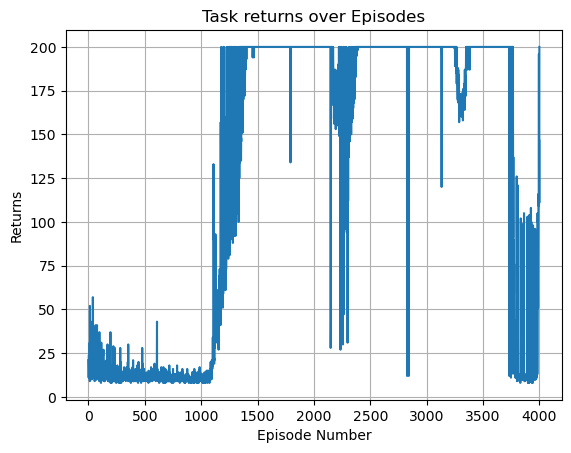

In [6]:
# Visualize the DQN training plots for the cartpole task
t.plot(save_name='cartpole_dqn.png', cfg_path=Path().cwd()/'cfg'/'cartpole_dqn.yaml',)

In [7]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'cartpole_dqn.yaml', cfg_args=dict(save_video=True))

Numpy/Torch/Random Seed:  436


error: XDG_RUNTIME_DIR not set in the environment.


{'episode': 0, 'ep_reward': 200.0}
{'episode': 1, 'ep_reward': 200.0}
{'episode': 2, 'ep_reward': 200.0}
{'episode': 3, 'ep_reward': 200.0}
{'episode': 4, 'ep_reward': 200.0}
{'episode': 5, 'ep_reward': 200.0}
{'episode': 6, 'ep_reward': 200.0}
{'episode': 7, 'ep_reward': 200.0}
{'episode': 8, 'ep_reward': 200.0}
{'episode': 9, 'ep_reward': 200.0}


In [8]:
Video(Path().cwd()/'results'/'CartPole-v1'/'video'/'test'/'ex4_dqn-episode-0.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

In [9]:
# init agent
with open(Path().cwd()/'cfg'/'lunarlander_dqn.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))
    
agent = DQNAgent(state_shape=cfg.state_shape, n_actions=cfg.n_actions, batch_size=cfg.batch_size, hidden_dims=cfg.hidden_dims,
                 gamma=cfg.gamma, lr=cfg.lr, tau=cfg.tau)

In [10]:
# Trainig takes approximately 60 mins,depends on server
t.train(agent, cfg_path=Path().cwd()/'cfg'/'lunarlander_dqn.yaml', cfg_args=dict()) 

Numpy/Torch/Random Seed:  436
{'ep_reward': -298.43039763456653, 'episode': 0, 'epsilon': 1.0, 'ep_avr': 0.014315474778413773, 'ts_avr': 0.0001323446235124101}
{'ep_reward': -33.45987022089028, 'episode': 100, 'epsilon': 0.6666666666666666, 'ep_avr': 0.28261978927999737, 'ts_avr': 0.002504915863193508, 'loss': 27.202869415283203, 'q_mean': -7.0680084228515625, 'num_update': 10423, 'update_time': 0.0017897561192512512}
{'ep_reward': 12.579905455104026, 'episode': 200, 'epsilon': 0.5, 'ep_avr': 0.39873317535966635, 'ts_avr': 0.0026887829488185075, 'loss': 13.534847259521484, 'q_mean': -5.412538528442383, 'num_update': 25235, 'update_time': 0.0018119998276233673}
{'ep_reward': -19.21748620138304, 'episode': 300, 'epsilon': 0.4, 'ep_avr': 0.7893682822212577, 'ts_avr': 0.0027389150631673626, 'loss': 9.478309631347656, 'q_mean': 1.5949994325637817, 'num_update': 54036, 'update_time': 0.0018855109810829163}
{'ep_reward': 76.9591629912211, 'episode': 400, 'epsilon': 0.3333333333333333, 'ep_avr

Numpy/Torch/Random Seed:  436


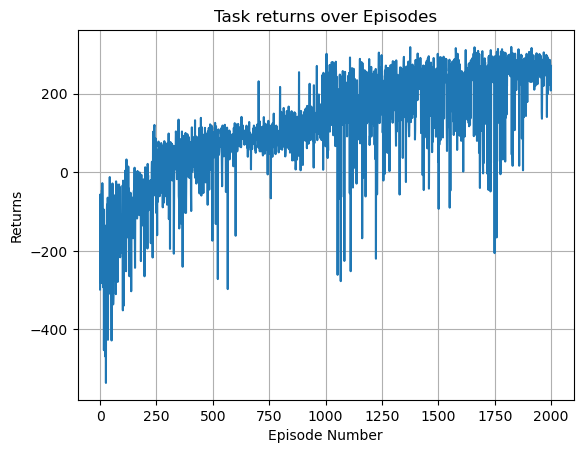

In [11]:
# Visualize the DQN training plots for the lunarlander task
t.plot(save_name='lunarlander_dqn.png', cfg_path=Path().cwd()/'cfg'/'lunarlander_dqn.yaml', cfg_args=dict())

In [12]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'lunarlander_dqn.yaml', cfg_args=dict(save_video=True))

Numpy/Torch/Random Seed:  436
{'episode': 0, 'ep_reward': 211.5553745014072}
{'episode': 1, 'ep_reward': 248.93502569842087}
{'episode': 2, 'ep_reward': 232.376646600706}
{'episode': 3, 'ep_reward': 265.2934187407319}
{'episode': 4, 'ep_reward': 251.87314157353876}
{'episode': 5, 'ep_reward': 258.0007615935454}
{'episode': 6, 'ep_reward': 210.9677293692533}
{'episode': 7, 'ep_reward': 270.0126798938546}
{'episode': 8, 'ep_reward': 268.38894964552264}
{'episode': 9, 'ep_reward': 295.69334254937337}


In [13]:
Video(Path().cwd()/'results'/'LunarLander-v2'/'video'/'test'/'ex4_dqn-episode-8.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Considering Continuous Action Spaces (5 points) </h3> 

Can Q-learning be used directly in environments with continuous action spaces?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


No, it's not suitable for environments with continuous action spaces because it relies on selecting a single discrete action at each time step.

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Continuous Action Spaces Part 1 (15 points) </h3> 

1.Which steps of the algorithm would be difficult to compute in case of a continuous action space?
    
2.If any, what could be done to solve them?
    
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


1. Action selection, maximization over actions, Q-Value updates and exploration could be difficult to compute in this case. In continuous action spaces, there is an infinite number of possible actions, so it's impractical to evaluate, compare or  maximize Q-values for all actions. In addition, exploration can be challenging as there are infinitely many possible actions to explore.

2. The solution for this would be to sample actions by using a policy network that parameterizes the action distribution.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.3</b> The Target Network (10 points) </h3> 

In DQN, we use an additional target network to calculate the target Q value.
    
1.Why we need an additional target network ? 
    
2.Can we just use the same network (no an additional target network ) in calculating both Q(s,a) and maxa(Q(s′,·))? why or why not?
    
3.What will happen if we do not stop gradient of the target Q value?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


1. We use an additional target network to improve the stability and convergence of the learning process. In Q-learning, we use our current Q-network to estimate the target Q-values while simultaneously updating the Q-network itsel. This can lead to instability and divergence during training, so we use an additional target network to solve this issue.

2. We shouldn't. If we use the same network for both estimating Q-values and target Q-values, we keep having the problem that was mentioned before: the Q-network is continuously chasing a changing target, which can lead to instability and slow convergence.

3. If we don't stop the gradient of the target Q-value, it can lead to a form of instability known as the "Q-learning off-policy bias". This can cause overestimation of Q-values and result in suboptimal policies.


# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex4_dpn.ipynb``` and ```ex4_rbf.ipynb```) are answered and and that the necessary plots are saved in the appropriate locations. The relevant plots and files needed to be submitted for this assignment are:


- Training performance plots:
  - `cartpole_dqn.png`: Cartpole, training performance plots in terms of episode and episodic reward
  - `lunarlander_dqn.png`: Lunarlander, training performance plots in terms of episode and episodic reward 
<br>
<br>

  

- Model files:
  - `dqn.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/CartPole-v1/cartpole_dqn``` Training result for Cartpole environment
- ```results/CartPole-v1/model/dqn.pt``` Model for Cartpole environment
- ```results/LunarLander-v2/lunarlander_dqn.png``` Training result for LunarLander environment
- ```results/LunarLander-v2/model/dqn.pt``` Model for LunarLander environment


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex4_rbf.ipynb```** </span>

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [ ]:
hrs = 7

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = 5   # Implementing DQN (10 points)
Q1_1 = 4 # Question 1.1 Considering Continuous Action Spaces (5 points)
Q1_2 = 4 # Question 1.2 Continuous Action Spaces Part 1 (15 points)
Q1_3 = 4 # Question 1.3 The Target Network (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [ ]:
T1 = 4   # Implementing DQN (10 points)
Q1_1 = 3 # Question 1.1 Considering Continuous Action Spaces (5 points)
Q1_2 = 3 # Question 1.2 Continuous Action Spaces Part 1 (15 points)
Q1_3 = 3 # Question 1.3 The Target Network (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE